## Carte d'incertitude sur la geolocalisation

Un script visant à obtenir une carte de l'incertitude sur la position d'un récepteur 
déduite des temps d'arrivée de signaux émis par des sources.
Une dérive de l'horloge est permise.

Les paramètres d'entrée sont:

- les positions géographiques des sources
- la position réelle du récepteur
- l'incertitude sur l'estimation de la distance source-récepteur

Une simulation de Monte Carlo est utilisée afin de construire la carte.


## Geolocation problem

Notations from Mobile Robotics (section 5.3). We assume we are in 2D.

$||\mathbf{x-x_1}|| = c(t_1-t_0) + \epsilon_0$

$||\mathbf{x-x_i}|| = c(\tau_i+t_1-t_0) + \epsilon_i$ for $i\in[2,N_s]$

<!--- We thus have $N_s$ equations. -->
Known variables are: $c$, $t_0$, $\mathbf{x_i}$, $\tau_i$.

Unknown variables are ($2+1+N_s$): 
- $\mathbf{x}$
- $t_1$ (time arrival of source 1 signal, may contain the receiver clock offset)
- $\epsilon_i$ (gaussian random variable with 0 mean and variance $e_i$).
<!--- The problem is undetermined because of the noise on the estimation of distances ($\epsilon_i$). -->

We consider the following minimization problem:

$J(\mathbf{x}, t_1) = \sum \Big ( ||\mathbf{x-x_1}|| - c(\tau_i+t_1-t_0) \Big )^2 / e_i^2 $

where $\tau_0=0$.


From Mobile Robotics (section 5.3):

"Multilateration is a localization technique based on measuring the difference of the distances between the robot and landmarks. Indeed, in a number of situations (such as in GPS localization), the clocks between the landmarks and robot are not synchronized and therefore we cannot directly measure the absolute distance between the landmarks and robot (by the propagation time of airwaves or soundwaves), but we can measure the difference between these distances. We will now give the principles of this technique.

Four landmarks emit a brief signal at the same time t0 which propagates with a speed c. Each emitted signal contains the identifier of the landmark, its position and the emission time t0. The robot (which does not have an accurate clock, only an accurate chronometer) receives the four signals at times ti. From this, it easily deduces the offsets between the reception times $\tau_i$"


In [1]:

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings(action='ignore')


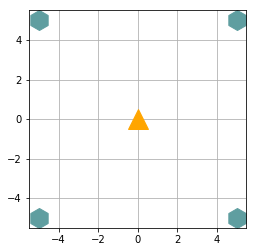

In [2]:

# sound speed
c = 1500. # m/s

# class for sources
class source(object):
    ''' A source object '''
    def __init__(self, x, y, e_i=10., label=''):
        ''' Input parameters:
        x,y  - horizontal position in meters
        e_i - uncertainty on the distance estimation
        label - a label for the source
        '''
        self.x=x
        self.y=y
        self.e_i=e_i
        self.tau_i=None
        self.label = 'source '+label
        
    def plot(self):
        plt.plot(self.x/1.e3,self.y/1.e3, color='cadetblue', marker='h', markersize=20, label=self.label)
    
    def set_tau_i(self,obj):
        self.tau_i = np.sqrt((self.x-obj.x)**2+(self.y-obj.y)**2)/c
    
    def get_epsilon(self,Np=1):
        epsilon = np.random.randn(Np)*self.e_i
        return epsilon
    

# class for receivers:
class receiver(object):
    ''' A receiver object '''
    def __init__(self, x, y, e_t=1., label=''):
        ''' Input parameters:
        x,y  - horizontal position in meters
        e_t - uncertainty on the clock drift in seconds
        label - a label for the receiver
        '''
        self.x=x
        self.y=y
        self.e_t=e_t 
        self.label = 'receiver '+label        

    def plot(self):
        plt.plot(self.x/1.e3,self.y/1.e3, color='orange', marker='^', markersize=20, label=self.label)



        
### create an ensemble of sources

# square formation:
dx=10. *1.e3 # in meters
sources=[]
sources.append(source(-dx*.5,-dx*.5))
sources.append(source(dx*.5,-dx*.5))
sources.append(source(dx*.5,dx*.5))
sources.append(source(-dx*.5,dx*.5))

# triangle formation:
#dx=10. *1.e4 # in meters
#sources=[]
#sources.append(source(-dx*.5,-dx.*5))
#sources.append(source(dx,-dx*.5))
#sources.append(source(0.,dx*.5))


### init a receiver
r=receiver(0. *1.e3,0. *1.e3)



### plot
plt.figure()
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()
ax.grid()
#ax.set_xlim([-1.,21.])
#ax.set_ylim([-1.,11.])
ax.set_aspect('equal')
plt.show()




In [3]:
### Monte-Carlo simulation of geolocations

# compute theoretical (true) arrival time based on distances
[s.set_tau_i(r) for s in sources]

# set t0 and clock offset
t0 = 0.
r.clock_offset = 1.  # in seconds, >0 when the receiver clock is ahead


# convert data into numpy arrays
xi = np.array([s.x for s in sources])
yi = np.array([s.y for s in sources])
ei = np.array([s.e_i for s in sources])


### loop over each ensemble member
Np=1000 # number of members
x=np.zeros(Np)
y=np.zeros(Np)
t1_received=np.zeros(Np)
t1_adjusted=np.zeros(Np)
for i in range(Np):
    # compute perturbed arrival times
    ti = t0 + np.array([s.tau_i+s.get_epsilon()/c for s in sources])[:,0] + r.clock_offset
    t1_received[i] = ti[0]
    taui = ti - ti[0]
    #
    fun = lambda x: np.sum( ( np.sqrt((x[0]-xi)**2 + (x[1]-yi)**2) - c*(taui + x[2] - t0) )**2 /ei**2 )
    res = minimize(fun,[0.,0.,0.])
    #
    x[i]=res.x[0]
    y[i]=res.x[1]
    t1_adjusted[i]=res.x[2]
    


mean(x) - x_true = 0.3 m
mean(y) - y_true = -0.0 m
sqrt(mean(||x-x_true||^2)) = 10.1 m
mean(t1_received) = 5.7 s
mean(t1_adjusted) = 4.7 s
mean(clock offset) = 1.0 s


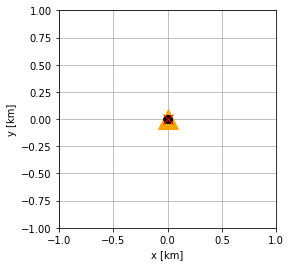

In [4]:
### compute the mean clock offset and print out useful info
clock_offset = t1_received.mean() - t1_adjusted.mean()

print('mean(x) - x_true = %.1f m' %(x.mean()-r.x))
print('mean(y) - y_true = %.1f m' %(y.mean()-r.y))
print('sqrt(mean(||x-x_true||^2)) = %.1f m' % np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) ))
print('mean(t1_received) = %.1f s' %(t1_received.mean()))
print('mean(t1_adjusted) = %.1f s' %(t1_adjusted.mean()))
print('mean(clock offset) = %.1f s' %(t1_received.mean()-t1_adjusted.mean()))



###  plot geolocations
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()

ax.plot(x/1.e3,y/1.e3,'k.')
ax.plot(x.mean()/1.e3,y.mean()/1.e3,'x',color='red',markersize=10)

dxs=1000. /1.e3
ax.set_xlim([r.x/1e3-dxs,r.x/1e3+dxs])
ax.set_ylim([r.y/1e3-dxs,r.y/1e3+dxs])
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.grid()
ax.set_aspect('equal')
plt.show()

In [5]:
#
# Compute now a map of errors
#

# target grid
Lx = 20.* 1.e3
Ly=Lx
xt = np.linspace(-Lx/2.,Lx/2.,30)
yt = np.linspace(-Ly/2.,Ly/2.,30)
Xt, Yt = np.meshgrid(xt,yt)

# init a receiver
r=receiver(5.e3,5.e3)
r.clock_offset = 1.  # in seconds, >0 when the receiver clock is ahead

def run_sim(rx,ry):
    # Monte Carlo ensemble numbers
    Np=100
    # update the receiver position
    r.x = rx
    r.y = ry
    # compute theoretical (true) arrival time based on distances
    [s.set_tau_i(r) for s in sources]
    #
    x=np.zeros(Np)
    y=np.zeros(Np)
    t1_received=np.zeros(Np)
    t1_adjusted=np.zeros(Np)
    for i in range(Np):
        # perturb arrival times
        ti = t0 + np.array([s.tau_i+s.get_epsilon()/c for s in sources])[:,0] + r.clock_offset
        t1_received[i] = ti[0]
        taui = ti - ti[0]
        #
        fun = lambda x: np.sum( ( np.sqrt((x[0]-xi)**2 + (x[1]-yi)**2) - c*(taui + x[2] - t0) )**2 /ei**2 )
        res = minimize(fun,(0.,0.,0.))
        #
        ax.plot(res.x[0]/1.e3,res.x[1]/1.e3,'k.')
        x[i]=res.x[0]
        y[i]=res.x[1]
        t1_adjusted[i]=res.x[2]
    # compute the mean of the error on the receiver position
    drms = np.sqrt( np.mean( (x - r.x)**2  + (y - r.y)**2 ) )
    # compute the clock offset
    clock_offset = t1_received.mean() - t1_adjusted.mean()
    return drms, x.mean()-r.x, y.mean()-r.y, clock_offset


drms = np.zeros_like(Xt)
xbias = np.zeros_like(Xt)
ybias = np.zeros_like(Xt)
clock_offset = np.zeros_like(Xt)
for i, j in np.ndindex(Xt.shape):
    drms[i,j], xbias[i,j], ybias[i,j], clock_offset[i,j] = run_sim(Xt[i,j],Yt[i,j])


min(drms) = 9.267447


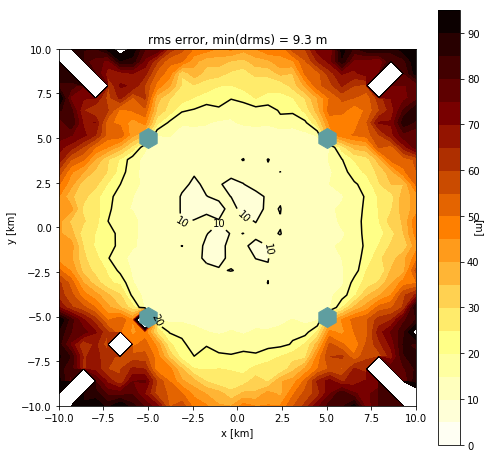

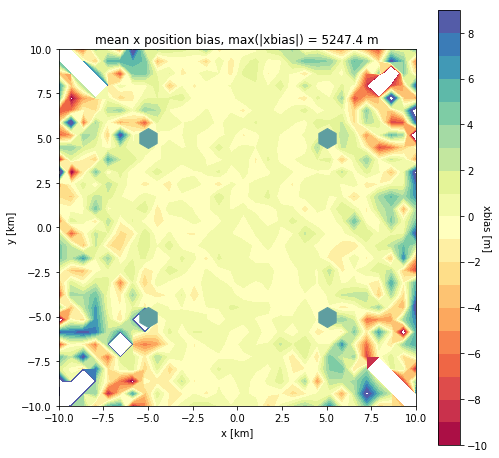

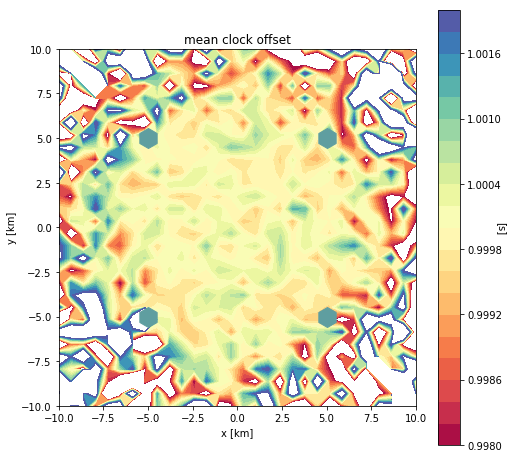

In [22]:

#
print('min(drms) = %f' % drms.min())


### plot the error map

cmap = plt.get_cmap('afmhot_r')

plt.figure(figsize=(8,8))
ax=plt.subplot(111)
lvls=np.arange(0.,1.e2,5.)
plt.contourf(Xt/1.e3,Yt/1.e3,drms,lvls,cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_ylabel('[m]', rotation=270)
CS = plt.contour(Xt/1.e3,Yt/1.e3,drms,[10,20],colors='k')
plt.clabel(CS, [10,20],  # label every second level
           inline=1,
           fmt='%1.0f',
           fontsize=10)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('rms error, min(drms) = %.1f m' % drms.min())
ax.set_aspect('equal')
plt.show()


cmap = plt.get_cmap('Spectral')

### bias in x direction
plt.figure(figsize=(8,8))
ax=plt.subplot(111)
lvls=np.arange(-1.e1,1.e1,1.e0)
plt.contourf(Xt/1.e3,Yt/1.e3,xbias,lvls,cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_ylabel('xbias [m]', rotation=270)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('mean x position bias, max(|xbias|) = %.1f m' % np.abs(xbias).max())
ax.set_aspect('equal')
plt.show()


### clock offset
plt.figure(figsize=(8,8))
ax=plt.subplot(111)
eps=2.e-3
lvls=np.arange(1.-eps,1.+eps,eps/10.)
plt.contourf(Xt/1.e3,Yt/1.e3,clock_offset,lvls,cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_ylabel('[s]', rotation=270)
[s.plot() for s in sources]
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.title('mean clock offset')
ax.set_aspect('equal')
plt.show()

